In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\UX431\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# DNN

In [2]:
df = pd.read_csv("Data\EPFToolbox\FR.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,69.720,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,57.100,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,54.490,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,54.950,65886.0,67823.0,2016-12-31,22


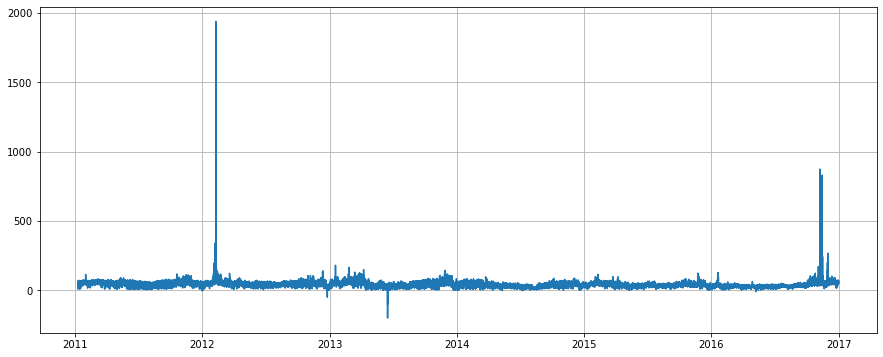

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [7]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [8]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [9]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

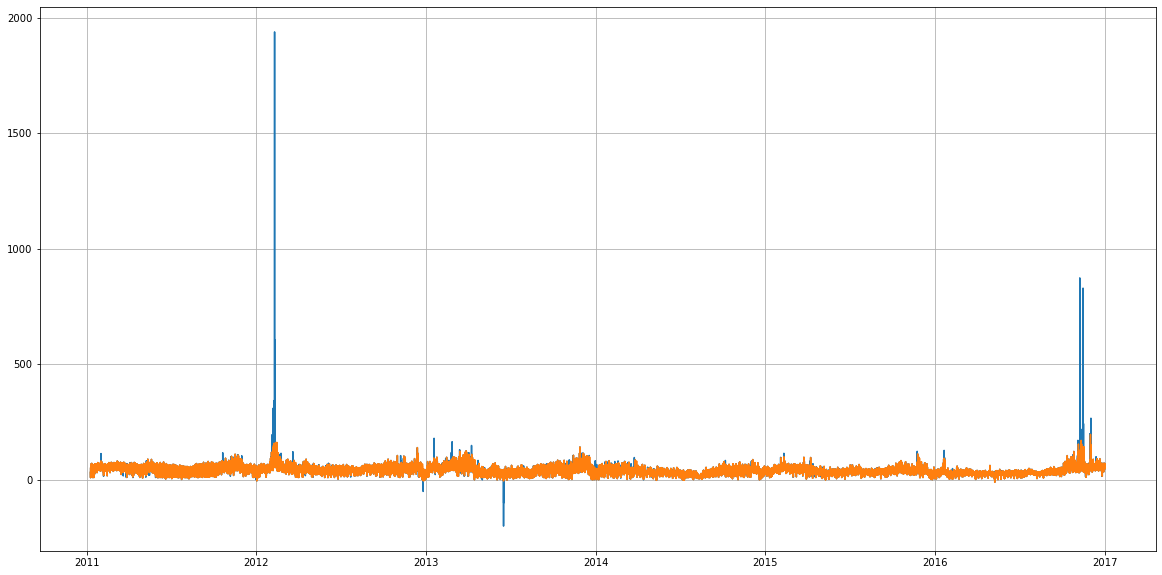

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [11]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [12]:
df.index = df.Date

In [13]:
df = df.drop(['Date'], axis = 1)

In [7]:
df.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [14]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [15]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [16]:
forecast_dates = forecast.index

In [17]:
df_original = pd.read_csv(r"Data\EPFToolbox\FR.csv")

In [18]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [19]:
df_original.index = df_original.Date

In [20]:
df_original = df_original.drop('Date', axis = 1)

In [21]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [22]:
df_original = df_original[df_original.index >= dt.datetime(2015, 1, 1)]

In [23]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [24]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,39.60,35.48,33.85,45.96,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,23.94,15.69,18.14,20.03,19.23,27.31,34.54,...,32.68,25.25,30.43,43.04,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,23.53,22.92,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,49.97,46.74,44.82,43.42,42.01,45.76,52.87,59.98,67.90,69.14,...,51.27,51.82,54.65,69.99,72.89,72.15,58.60,51.48,51.27,51.48
2016-12-28,48.31,45.76,43.03,40.46,39.34,40.83,44.80,51.00,53.00,56.90,...,50.77,51.60,55.20,63.28,63.70,59.82,62.36,50.00,49.02,47.73
2016-12-29,42.40,39.30,36.83,34.11,34.99,37.64,47.30,51.27,57.42,58.03,...,49.60,51.63,54.43,63.95,67.17,66.40,59.41,51.72,56.44,55.20


In [25]:
from epftoolbox.models import hyperparameter_optimizer

In [26]:
df.to_csv("Data/EPFToolbox/FR_dnn_no_outliers.csv")

In [27]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "FR_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 2

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = 4

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00


Tested 1/100 iterations.
Best MAE - Validation Dataset
  MAE: 8.4 | sMAPE: 20.42 %

Best MAE - Test Dataset
  MAE: 8.3 | sMAPE: 23.60 %


Tested 2/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.4 | sMAPE: 13.51 %

Best MAE - Test Dataset
  MAE: 4.8 | sMAPE: 14.24 %


Tested 3/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.4 | sMAPE: 13.51 %

Best MAE - Test Dataset
  MAE: 4.8 | sMAPE: 14.24 %


Tested 4/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.4 | sMAPE: 13.51 %

Best MAE - Test Dataset
  MAE: 4.8 | sMAPE: 14.24 %


Tested 5/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.4 | sMAPE: 13.51 %

Best MAE - Test Dataset
  MAE: 4.8 | sMAPE: 14.24 %


Tested 6/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.4 | sMAPE: 13.51 %

Best MAE - Test Dataset
  MAE: 4.8 | sMAPE: 14.24 %


Tested 7/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.4 | sMAPE: 13.51 %

Best MAE - Test Dataset
  MAE



Tested 60/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.1 | sMAPE: 12.75 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 12.98 %


Tested 61/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.1 | sMAPE: 12.75 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 12.98 %


Tested 62/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.1 | sMAPE: 12.75 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 12.98 %


Tested 63/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.1 | sMAPE: 12.75 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 12.98 %


Tested 64/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.1 | sMAPE: 12.75 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 12.98 %


Tested 65/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.1 | sMAPE: 12.75 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 12.98 %


Tested 66/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.1 | sMAPE: 12.75 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 12.98 %


Tested 67/100 iterations.

In [28]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "FR_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 2

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_FR_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = 4
experiment_id = 1

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00
2015-01-01 - sMAPE: 11.25%  |  MAE: 4.472
2015-01-02 - sMAPE: 11.17%  |  MAE: 4.349
2015-01-03 - sMAPE: 10.21%  |  MAE: 3.950
2015-01-04 - sMAPE: 10.62%  |  MAE: 3.845
2015-01-05 - sMAPE: 10.85%  |  MAE: 4.235
2015-01-06 - sMAPE: 10.72%  |  MAE: 4.336
2015-01-07 - sMAPE: 9.88%  |  MAE: 4.029
2015-01-08 - sMAPE: 9.49%  |  MAE: 3.896
2015-01-09 - sMAPE: 10.89%  |  MAE: 4.313
2015-01-10 - sMAPE: 12.28%  |  MAE: 4.361
2015-01-11 - sMAPE: 13.87%  |  MAE: 4.558
2015-01-12 - sMAPE: 13.46%  |  MAE: 4.452
2015-01-13 - sMAPE: 13.15%  |  MAE: 4.342
2015-01-14 - sMAPE: 13.28%  |  MAE: 4.414
2015-01-15 - sMAPE: 13.07%  |  MAE: 4.312
2015-01-16 - sMAPE: 13.36%  |  MAE: 4.421
2015-01-17 - sMAPE: 13.07%  |  MAE: 4.343
2015-01-18 - sMAPE: 12.81%  |  MAE: 4.270
2015-01-19 - sMAPE: 12.44%  |  MAE: 4.197
2015-01-20 - sMAPE: 12.00%  |  MAE: 4.074
2015-01-21 - sMAPE: 11.73%  |  MAE: 4.027
2015-01-22 - sMAPE: 11.35%  |  MAE: 3.921
2015-01-23 - sMAPE: 1

2015-07-16 - sMAPE: 12.07%  |  MAE: 4.148
2015-07-17 - sMAPE: 12.04%  |  MAE: 4.143
2015-07-18 - sMAPE: 12.04%  |  MAE: 4.143
2015-07-19 - sMAPE: 12.04%  |  MAE: 4.141
2015-07-20 - sMAPE: 12.02%  |  MAE: 4.136
2015-07-21 - sMAPE: 12.02%  |  MAE: 4.145
2015-07-22 - sMAPE: 12.00%  |  MAE: 4.146
2015-07-23 - sMAPE: 11.98%  |  MAE: 4.142
2015-07-24 - sMAPE: 11.95%  |  MAE: 4.134
2015-07-25 - sMAPE: 12.12%  |  MAE: 4.175
2015-07-26 - sMAPE: 12.25%  |  MAE: 4.194
2015-07-27 - sMAPE: 12.31%  |  MAE: 4.207
2015-07-28 - sMAPE: 12.33%  |  MAE: 4.211
2015-07-29 - sMAPE: 12.32%  |  MAE: 4.206
2015-07-30 - sMAPE: 12.33%  |  MAE: 4.206
2015-07-31 - sMAPE: 12.29%  |  MAE: 4.194
2015-08-01 - sMAPE: 12.31%  |  MAE: 4.191
2015-08-02 - sMAPE: 12.29%  |  MAE: 4.179
2015-08-03 - sMAPE: 12.27%  |  MAE: 4.171
2015-08-04 - sMAPE: 12.27%  |  MAE: 4.170
2015-08-05 - sMAPE: 12.25%  |  MAE: 4.165
2015-08-06 - sMAPE: 12.22%  |  MAE: 4.154
2015-08-07 - sMAPE: 12.19%  |  MAE: 4.144
2015-08-08 - sMAPE: 12.17%  |  MAE

2016-01-28 - sMAPE: 12.43%  |  MAE: 4.268
2016-01-29 - sMAPE: 12.43%  |  MAE: 4.267
2016-01-30 - sMAPE: 12.46%  |  MAE: 4.268
2016-01-31 - sMAPE: 12.47%  |  MAE: 4.263
2016-02-01 - sMAPE: 12.50%  |  MAE: 4.271
2016-02-02 - sMAPE: 12.52%  |  MAE: 4.268
2016-02-03 - sMAPE: 12.54%  |  MAE: 4.271
2016-02-04 - sMAPE: 12.54%  |  MAE: 4.269
2016-02-05 - sMAPE: 12.54%  |  MAE: 4.267
2016-02-06 - sMAPE: 12.59%  |  MAE: 4.274
2016-02-07 - sMAPE: 12.64%  |  MAE: 4.276
2016-02-08 - sMAPE: 12.69%  |  MAE: 4.280
2016-02-09 - sMAPE: 12.68%  |  MAE: 4.274
2016-02-10 - sMAPE: 12.67%  |  MAE: 4.269
2016-02-11 - sMAPE: 12.66%  |  MAE: 4.264
2016-02-12 - sMAPE: 12.66%  |  MAE: 4.264
2016-02-13 - sMAPE: 12.66%  |  MAE: 4.261
2016-02-14 - sMAPE: 12.70%  |  MAE: 4.261
2016-02-15 - sMAPE: 12.72%  |  MAE: 4.266
2016-02-16 - sMAPE: 12.71%  |  MAE: 4.265
2016-02-17 - sMAPE: 12.70%  |  MAE: 4.260
2016-02-18 - sMAPE: 12.70%  |  MAE: 4.260
2016-02-19 - sMAPE: 12.70%  |  MAE: 4.260
2016-02-20 - sMAPE: 12.69%  |  MAE

2016-08-11 - sMAPE: 12.36%  |  MAE: 3.801
2016-08-12 - sMAPE: 12.35%  |  MAE: 3.799
2016-08-13 - sMAPE: 12.37%  |  MAE: 3.799
2016-08-14 - sMAPE: 12.39%  |  MAE: 3.801
2016-08-15 - sMAPE: 12.38%  |  MAE: 3.798
2016-08-16 - sMAPE: 12.37%  |  MAE: 3.795
2016-08-17 - sMAPE: 12.37%  |  MAE: 3.794
2016-08-18 - sMAPE: 12.35%  |  MAE: 3.789
2016-08-19 - sMAPE: 12.35%  |  MAE: 3.789
2016-08-20 - sMAPE: 12.35%  |  MAE: 3.787
2016-08-21 - sMAPE: 12.37%  |  MAE: 3.787
2016-08-22 - sMAPE: 12.36%  |  MAE: 3.784
2016-08-23 - sMAPE: 12.35%  |  MAE: 3.780
2016-08-24 - sMAPE: 12.34%  |  MAE: 3.778
2016-08-25 - sMAPE: 12.33%  |  MAE: 3.777
2016-08-26 - sMAPE: 12.33%  |  MAE: 3.776
2016-08-27 - sMAPE: 12.33%  |  MAE: 3.776
2016-08-28 - sMAPE: 12.33%  |  MAE: 3.776
2016-08-29 - sMAPE: 12.32%  |  MAE: 3.775
2016-08-30 - sMAPE: 12.31%  |  MAE: 3.772
2016-08-31 - sMAPE: 12.30%  |  MAE: 3.769
2016-09-01 - sMAPE: 12.29%  |  MAE: 3.766
2016-09-02 - sMAPE: 12.28%  |  MAE: 3.765
2016-09-03 - sMAPE: 12.28%  |  MAE

In [29]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,45.823544,42.312378,37.669781,31.978302,28.577671,28.945175,29.534296,30.950106,33.036716,37.118629,...,36.396507,34.819168,35.798985,44.246567,55.838387,58.26849,53.056309,47.809525,50.515804,48.607471
2015-01-02,45.604568,42.189137,38.669346,34.325829,32.846237,34.509953,38.268646,42.110603,44.37468,46.576408,...,41.304836,39.687893,40.553108,48.316509,57.976025,59.614098,53.354984,48.102341,50.784847,47.379524
2015-01-03,38.202366,34.895264,31.283171,27.387926,26.723707,28.531944,34.524872,40.665245,42.963249,44.559559,...,37.958206,35.778225,36.61721,44.007202,52.460659,53.771637,46.642841,41.944485,43.407265,41.611393
2015-01-04,39.43404,34.885506,31.173801,26.540506,24.652294,24.757978,24.211605,24.603876,28.102251,31.287086,...,28.746174,27.196148,28.409288,36.009342,46.947376,50.706837,47.144337,42.028721,45.629387,42.889835
2015-01-05,37.613071,33.869076,29.992723,26.261066,25.910059,31.771425,41.881134,53.522346,56.81218,56.714298,...,54.046951,52.875122,54.218037,63.885994,70.469696,64.6362,57.804424,49.795391,50.759541,47.52795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,44.258015,40.865219,37.455593,33.364243,32.89011,36.896614,46.363747,55.056137,57.869045,57.349487,...,52.099205,49.607662,49.912403,56.064835,62.318222,65.43998,59.286926,51.881863,52.59642,49.379265
2016-12-28,48.176083,45.323597,42.922382,38.118805,37.341389,40.428753,48.944229,57.585526,60.463715,61.492279,...,50.330242,47.877689,47.955196,53.404194,61.865284,66.961815,59.393158,52.526707,53.090168,50.235626
2016-12-29,43.262749,40.847054,37.711369,33.891186,32.733395,35.894814,44.29908,53.242645,56.419914,57.175701,...,50.745911,48.673615,49.074394,56.570419,63.911606,66.012993,57.59351,49.991089,50.499454,48.549408


In [30]:
forecast.to_csv("Resultados/dnn_FR_final_no_outliers.csv")

# DNN + Estandarización móvil

In [2]:
with open('dict_new_df_fr_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [3]:
df_nuevo = pd.DataFrame(dict_new_df)

In [4]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [5]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [6]:
df_scalers

,Date,scaler
0,2011-01-16 00:00:00,StandardScaler()
1,2011-01-16 01:00:00,StandardScaler()
2,2011-01-16 02:00:00,StandardScaler()
3,2011-01-16 03:00:00,StandardScaler()
4,2011-01-16 04:00:00,StandardScaler()
...,...,...
52243,2016-12-31 19:00:00,StandardScaler()
52244,2016-12-31 20:00:00,StandardScaler()
52245,2016-12-31 21:00:00,StandardScaler()
52246,2016-12-31 22:00:00,StandardScaler()


In [7]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']]

In [8]:
df_nuevo.columns = ['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']

In [9]:
df_nuevo = df_nuevo.set_index('Date')

In [10]:
df_nuevo.to_csv("Data/EPFToolbox/FR_dnn_estandarizacion_movil_no_outliers.csv")

In [11]:
from epftoolbox.models import hyperparameter_optimizer

In [12]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "FR_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = None

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 2

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00


Tested 1/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.6 | sMAPE: 99.18 %

Best MAE - Test Dataset
  MAE: 0.7 | sMAPE: 104.12 %


Tested 2/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 66.81 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 71.26 %


Tested 3/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 66.81 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 71.26 %


Tested 4/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 66.81 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 71.26 %


Tested 5/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 66.81 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 71.26 %


Tested 6/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 66.81 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 71.26 %


Tested 7/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 63.70 %

Best MAE - Test Dataset
  MA



Tested 60/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 62.83 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 67.18 %


Tested 61/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 62.83 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 67.18 %


Tested 62/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 62.83 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 67.18 %


Tested 63/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 62.83 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 67.18 %


Tested 64/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 62.83 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 67.18 %


Tested 65/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 62.83 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 67.18 %


Tested 66/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 62.83 %

Best MAE - Test Dataset
  MAE: 0.4 | sMAPE: 67.18 %


Tested 67/100 iterations.

In [11]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "FR_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_FR_estandarizacion_movil_final_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = None
experiment_id = 2

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00
2015-01-01 - sMAPE: 76.66%  |  MAE: 0.292
2015-01-02 - sMAPE: 78.44%  |  MAE: 0.294
2015-01-03 - sMAPE: 94.77%  |  MAE: 0.335
2015-01-04 - sMAPE: 86.87%  |  MAE: 0.354
2015-01-05 - sMAPE: 81.03%  |  MAE: 0.343
2015-01-06 - sMAPE: 77.17%  |  MAE: 0.331
2015-01-07 - sMAPE: 73.56%  |  MAE: 0.321
2015-01-08 - sMAPE: 72.87%  |  MAE: 0.316
2015-01-09 - sMAPE: 76.46%  |  MAE: 0.357
2015-01-10 - sMAPE: 76.53%  |  MAE: 0.438
2015-01-11 - sMAPE: 74.37%  |  MAE: 0.451
2015-01-12 - sMAPE: 72.50%  |  MAE: 0.428
2015-01-13 - sMAPE: 71.41%  |  MAE: 0.411
2015-01-14 - sMAPE: 72.59%  |  MAE: 0.409
2015-01-15 - sMAPE: 70.58%  |  MAE: 0.396
2015-01-16 - sMAPE: 71.41%  |  MAE: 0.407
2015-01-17 - sMAPE: 71.19%  |  MAE: 0.394
2015-01-18 - sMAPE: 72.48%  |  MAE: 0.392
2015-01-19 - sMAPE: 70.07%  |  MAE: 0.383
2015-01-20 - sMAPE: 68.33%  |  MAE: 0.375
2015-01-21 - sMAPE: 67.17%  |  MAE: 0.370
2015-01-22 - sMAPE: 66.59%  |  MAE: 0.369
2015-01-23 - sMAPE:

2015-07-14 - sMAPE: 71.15%  |  MAE: 0.396
2015-07-15 - sMAPE: 71.12%  |  MAE: 0.397
2015-07-16 - sMAPE: 70.93%  |  MAE: 0.396
2015-07-17 - sMAPE: 70.92%  |  MAE: 0.397
2015-07-18 - sMAPE: 71.01%  |  MAE: 0.396
2015-07-19 - sMAPE: 71.01%  |  MAE: 0.396
2015-07-20 - sMAPE: 70.86%  |  MAE: 0.396
2015-07-21 - sMAPE: 70.85%  |  MAE: 0.397
2015-07-22 - sMAPE: 70.82%  |  MAE: 0.398
2015-07-23 - sMAPE: 70.66%  |  MAE: 0.397
2015-07-24 - sMAPE: 70.65%  |  MAE: 0.397
2015-07-25 - sMAPE: 71.07%  |  MAE: 0.401
2015-07-26 - sMAPE: 70.97%  |  MAE: 0.404
2015-07-27 - sMAPE: 71.33%  |  MAE: 0.406
2015-07-28 - sMAPE: 71.42%  |  MAE: 0.406
2015-07-29 - sMAPE: 71.57%  |  MAE: 0.405
2015-07-30 - sMAPE: 71.82%  |  MAE: 0.406
2015-07-31 - sMAPE: 71.68%  |  MAE: 0.404
2015-08-01 - sMAPE: 71.78%  |  MAE: 0.404
2015-08-02 - sMAPE: 71.65%  |  MAE: 0.404
2015-08-03 - sMAPE: 71.68%  |  MAE: 0.404
2015-08-04 - sMAPE: 71.70%  |  MAE: 0.405
2015-08-05 - sMAPE: 71.58%  |  MAE: 0.405
2015-08-06 - sMAPE: 71.39%  |  MAE

2016-01-26 - sMAPE: 69.00%  |  MAE: 0.393
2016-01-27 - sMAPE: 68.99%  |  MAE: 0.392
2016-01-28 - sMAPE: 68.97%  |  MAE: 0.392
2016-01-29 - sMAPE: 69.00%  |  MAE: 0.392
2016-01-30 - sMAPE: 68.99%  |  MAE: 0.393
2016-01-31 - sMAPE: 68.91%  |  MAE: 0.393
2016-02-01 - sMAPE: 68.89%  |  MAE: 0.392
2016-02-02 - sMAPE: 68.92%  |  MAE: 0.392
2016-02-03 - sMAPE: 68.95%  |  MAE: 0.392
2016-02-04 - sMAPE: 68.91%  |  MAE: 0.392
2016-02-05 - sMAPE: 68.89%  |  MAE: 0.392
2016-02-06 - sMAPE: 68.98%  |  MAE: 0.392
2016-02-07 - sMAPE: 68.92%  |  MAE: 0.392
2016-02-08 - sMAPE: 68.94%  |  MAE: 0.391
2016-02-09 - sMAPE: 68.87%  |  MAE: 0.391
2016-02-10 - sMAPE: 68.78%  |  MAE: 0.391
2016-02-11 - sMAPE: 68.72%  |  MAE: 0.390
2016-02-12 - sMAPE: 68.71%  |  MAE: 0.390
2016-02-13 - sMAPE: 68.79%  |  MAE: 0.390
2016-02-14 - sMAPE: 68.73%  |  MAE: 0.390
2016-02-15 - sMAPE: 68.74%  |  MAE: 0.389
2016-02-16 - sMAPE: 68.68%  |  MAE: 0.390
2016-02-17 - sMAPE: 68.63%  |  MAE: 0.389
2016-02-18 - sMAPE: 68.58%  |  MAE

2016-08-09 - sMAPE: 67.68%  |  MAE: 0.376
2016-08-10 - sMAPE: 67.66%  |  MAE: 0.376
2016-08-11 - sMAPE: 67.64%  |  MAE: 0.376
2016-08-12 - sMAPE: 67.62%  |  MAE: 0.376
2016-08-13 - sMAPE: 67.59%  |  MAE: 0.376
2016-08-14 - sMAPE: 67.61%  |  MAE: 0.376
2016-08-15 - sMAPE: 67.62%  |  MAE: 0.376
2016-08-16 - sMAPE: 67.56%  |  MAE: 0.376
2016-08-17 - sMAPE: 67.51%  |  MAE: 0.376
2016-08-18 - sMAPE: 67.47%  |  MAE: 0.375
2016-08-19 - sMAPE: 67.44%  |  MAE: 0.375
2016-08-20 - sMAPE: 67.41%  |  MAE: 0.375
2016-08-21 - sMAPE: 67.42%  |  MAE: 0.376
2016-08-22 - sMAPE: 67.35%  |  MAE: 0.376
2016-08-23 - sMAPE: 67.29%  |  MAE: 0.375
2016-08-24 - sMAPE: 67.22%  |  MAE: 0.375
2016-08-25 - sMAPE: 67.16%  |  MAE: 0.375
2016-08-26 - sMAPE: 67.12%  |  MAE: 0.375
2016-08-27 - sMAPE: 67.14%  |  MAE: 0.375
2016-08-28 - sMAPE: 67.13%  |  MAE: 0.375
2016-08-29 - sMAPE: 67.14%  |  MAE: 0.375
2016-08-30 - sMAPE: 67.11%  |  MAE: 0.375
2016-08-31 - sMAPE: 67.06%  |  MAE: 0.375
2016-09-01 - sMAPE: 67.00%  |  MAE

In [12]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.796835,0.586132,0.247922,-0.184587,-0.542455,-0.540965,-0.459364,-0.224934,0.068652,0.359052,...,-0.049663,-0.130064,-0.099062,0.361402,1.067294,1.137176,0.883177,0.548197,0.735645,0.794666
2015-01-02,0.379721,0.104323,-0.221954,-0.602249,-0.91033,-0.792652,-0.64419,-0.463606,-0.095605,0.190615,...,-0.10431,-0.257964,-0.154992,0.42747,1.094736,1.085851,0.714958,0.337811,0.591917,0.413597
2015-01-03,-0.170917,-0.461439,-0.731412,-1.075875,-1.288551,-1.205093,-1.064437,-0.695416,-0.386835,-0.202742,...,-0.480941,-0.638108,-0.564118,0.005294,0.634678,0.545864,0.078074,-0.226093,0.090785,-0.038342
2015-01-04,-0.688238,-0.965955,-1.358029,-1.740904,-2.024568,-1.8304,-1.757227,-1.584613,-1.255924,-0.939986,...,-1.307753,-1.443894,-1.368522,-0.684057,0.19441,0.71059,0.262196,-0.226875,-0.014383,-0.390176
2015-01-05,-0.57351,-0.90894,-1.207923,-1.646003,-1.688806,-1.169745,-0.218913,0.507592,0.761389,0.782731,...,0.351453,0.214539,0.302673,0.862177,1.525334,1.426583,0.923799,0.377939,0.461165,0.240252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,-0.664662,-0.922355,-1.151715,-1.534875,-1.671631,-1.311545,-0.721478,-0.048439,0.082285,0.08666,...,-0.370143,-0.392753,-0.310355,0.242244,0.661664,0.489285,0.042497,-0.356738,-0.29023,-0.467931
2016-12-28,-0.46517,-0.683991,-0.838432,-1.105187,-1.202859,-1.020057,-0.538534,0.142753,0.355423,0.345782,...,-0.306119,-0.379365,-0.200554,0.451327,0.973602,0.74469,0.165077,-0.379942,-0.22529,-0.376863
2016-12-29,-0.350135,-0.630339,-0.848891,-1.10421,-1.228585,-0.958159,-0.488553,0.106808,0.29709,0.379982,...,0.069231,-0.000092,0.13287,0.814726,1.277701,0.972796,0.501844,0.082322,0.244083,0.036777


In [13]:
forecast.to_csv("Resultados/dnn_FR_estandarizacion_movil_final_no_outliers.csv")

In [14]:
df_test_original = pd.DataFrame(forecast.values.reshape((-1,)), columns=['Price'])
df_test_original['Date'] = df_scalers.tail(len(df_test_original)).Date.to_numpy()

In [15]:
predicciones = np.array([])
for cont in range(0, len(df_test_original)):
    
    print(df_test_original.iloc[cont].Date)
    
    # Acumulamos las predicciones
    scaler_obj = df_scalers[df_scalers.Date == df_test_original.iloc[cont].Date].scaler.values[0]

    predicciones = np.append(predicciones, scaler_obj.inverse_transform(np.array(df_test_original.iloc[cont].Price).reshape(1, -1))[0][0])

2015-01-01 00:00:00
2015-01-01 01:00:00
2015-01-01 02:00:00
2015-01-01 03:00:00
2015-01-01 04:00:00
2015-01-01 05:00:00
2015-01-01 06:00:00
2015-01-01 07:00:00
2015-01-01 08:00:00
2015-01-01 09:00:00
2015-01-01 10:00:00
2015-01-01 11:00:00
2015-01-01 12:00:00
2015-01-01 13:00:00
2015-01-01 14:00:00
2015-01-01 15:00:00
2015-01-01 16:00:00
2015-01-01 17:00:00
2015-01-01 18:00:00
2015-01-01 19:00:00
2015-01-01 20:00:00
2015-01-01 21:00:00
2015-01-01 22:00:00
2015-01-01 23:00:00
2015-01-02 00:00:00
2015-01-02 01:00:00
2015-01-02 02:00:00
2015-01-02 03:00:00
2015-01-02 04:00:00
2015-01-02 05:00:00
2015-01-02 06:00:00
2015-01-02 07:00:00
2015-01-02 08:00:00
2015-01-02 09:00:00
2015-01-02 10:00:00
2015-01-02 11:00:00
2015-01-02 12:00:00
2015-01-02 13:00:00
2015-01-02 14:00:00
2015-01-02 15:00:00
2015-01-02 16:00:00
2015-01-02 17:00:00
2015-01-02 18:00:00
2015-01-02 19:00:00
2015-01-02 20:00:00
2015-01-02 21:00:00
2015-01-02 22:00:00
2015-01-02 23:00:00
2015-01-03 00:00:00
2015-01-03 01:00:00


2015-01-18 14:00:00
2015-01-18 15:00:00
2015-01-18 16:00:00
2015-01-18 17:00:00
2015-01-18 18:00:00
2015-01-18 19:00:00
2015-01-18 20:00:00
2015-01-18 21:00:00
2015-01-18 22:00:00
2015-01-18 23:00:00
2015-01-19 00:00:00
2015-01-19 01:00:00
2015-01-19 02:00:00
2015-01-19 03:00:00
2015-01-19 04:00:00
2015-01-19 05:00:00
2015-01-19 06:00:00
2015-01-19 07:00:00
2015-01-19 08:00:00
2015-01-19 09:00:00
2015-01-19 10:00:00
2015-01-19 11:00:00
2015-01-19 12:00:00
2015-01-19 13:00:00
2015-01-19 14:00:00
2015-01-19 15:00:00
2015-01-19 16:00:00
2015-01-19 17:00:00
2015-01-19 18:00:00
2015-01-19 19:00:00
2015-01-19 20:00:00
2015-01-19 21:00:00
2015-01-19 22:00:00
2015-01-19 23:00:00
2015-01-20 00:00:00
2015-01-20 01:00:00
2015-01-20 02:00:00
2015-01-20 03:00:00
2015-01-20 04:00:00
2015-01-20 05:00:00
2015-01-20 06:00:00
2015-01-20 07:00:00
2015-01-20 08:00:00
2015-01-20 09:00:00
2015-01-20 10:00:00
2015-01-20 11:00:00
2015-01-20 12:00:00
2015-01-20 13:00:00
2015-01-20 14:00:00
2015-01-20 15:00:00


2015-02-05 11:00:00
2015-02-05 12:00:00
2015-02-05 13:00:00
2015-02-05 14:00:00
2015-02-05 15:00:00
2015-02-05 16:00:00
2015-02-05 17:00:00
2015-02-05 18:00:00
2015-02-05 19:00:00
2015-02-05 20:00:00
2015-02-05 21:00:00
2015-02-05 22:00:00
2015-02-05 23:00:00
2015-02-06 00:00:00
2015-02-06 01:00:00
2015-02-06 02:00:00
2015-02-06 03:00:00
2015-02-06 04:00:00
2015-02-06 05:00:00
2015-02-06 06:00:00
2015-02-06 07:00:00
2015-02-06 08:00:00
2015-02-06 09:00:00
2015-02-06 10:00:00
2015-02-06 11:00:00
2015-02-06 12:00:00
2015-02-06 13:00:00
2015-02-06 14:00:00
2015-02-06 15:00:00
2015-02-06 16:00:00
2015-02-06 17:00:00
2015-02-06 18:00:00
2015-02-06 19:00:00
2015-02-06 20:00:00
2015-02-06 21:00:00
2015-02-06 22:00:00
2015-02-06 23:00:00
2015-02-07 00:00:00
2015-02-07 01:00:00
2015-02-07 02:00:00
2015-02-07 03:00:00
2015-02-07 04:00:00
2015-02-07 05:00:00
2015-02-07 06:00:00
2015-02-07 07:00:00
2015-02-07 08:00:00
2015-02-07 09:00:00
2015-02-07 10:00:00
2015-02-07 11:00:00
2015-02-07 12:00:00


2015-02-23 02:00:00
2015-02-23 03:00:00
2015-02-23 04:00:00
2015-02-23 05:00:00
2015-02-23 06:00:00
2015-02-23 07:00:00
2015-02-23 08:00:00
2015-02-23 09:00:00
2015-02-23 10:00:00
2015-02-23 11:00:00
2015-02-23 12:00:00
2015-02-23 13:00:00
2015-02-23 14:00:00
2015-02-23 15:00:00
2015-02-23 16:00:00
2015-02-23 17:00:00
2015-02-23 18:00:00
2015-02-23 19:00:00
2015-02-23 20:00:00
2015-02-23 21:00:00
2015-02-23 22:00:00
2015-02-23 23:00:00
2015-02-24 00:00:00
2015-02-24 01:00:00
2015-02-24 02:00:00
2015-02-24 03:00:00
2015-02-24 04:00:00
2015-02-24 05:00:00
2015-02-24 06:00:00
2015-02-24 07:00:00
2015-02-24 08:00:00
2015-02-24 09:00:00
2015-02-24 10:00:00
2015-02-24 11:00:00
2015-02-24 12:00:00
2015-02-24 13:00:00
2015-02-24 14:00:00
2015-02-24 15:00:00
2015-02-24 16:00:00
2015-02-24 17:00:00
2015-02-24 18:00:00
2015-02-24 19:00:00
2015-02-24 20:00:00
2015-02-24 21:00:00
2015-02-24 22:00:00
2015-02-24 23:00:00
2015-02-25 00:00:00
2015-02-25 01:00:00
2015-02-25 02:00:00
2015-02-25 03:00:00


2015-03-12 12:00:00
2015-03-12 13:00:00
2015-03-12 14:00:00
2015-03-12 15:00:00
2015-03-12 16:00:00
2015-03-12 17:00:00
2015-03-12 18:00:00
2015-03-12 19:00:00
2015-03-12 20:00:00
2015-03-12 21:00:00
2015-03-12 22:00:00
2015-03-12 23:00:00
2015-03-13 00:00:00
2015-03-13 01:00:00
2015-03-13 02:00:00
2015-03-13 03:00:00
2015-03-13 04:00:00
2015-03-13 05:00:00
2015-03-13 06:00:00
2015-03-13 07:00:00
2015-03-13 08:00:00
2015-03-13 09:00:00
2015-03-13 10:00:00
2015-03-13 11:00:00
2015-03-13 12:00:00
2015-03-13 13:00:00
2015-03-13 14:00:00
2015-03-13 15:00:00
2015-03-13 16:00:00
2015-03-13 17:00:00
2015-03-13 18:00:00
2015-03-13 19:00:00
2015-03-13 20:00:00
2015-03-13 21:00:00
2015-03-13 22:00:00
2015-03-13 23:00:00
2015-03-14 00:00:00
2015-03-14 01:00:00
2015-03-14 02:00:00
2015-03-14 03:00:00
2015-03-14 04:00:00
2015-03-14 05:00:00
2015-03-14 06:00:00
2015-03-14 07:00:00
2015-03-14 08:00:00
2015-03-14 09:00:00
2015-03-14 10:00:00
2015-03-14 11:00:00
2015-03-14 12:00:00
2015-03-14 13:00:00


2015-03-31 14:00:00
2015-03-31 15:00:00
2015-03-31 16:00:00
2015-03-31 17:00:00
2015-03-31 18:00:00
2015-03-31 19:00:00
2015-03-31 20:00:00
2015-03-31 21:00:00
2015-03-31 22:00:00
2015-03-31 23:00:00
2015-04-01 00:00:00
2015-04-01 01:00:00
2015-04-01 02:00:00
2015-04-01 03:00:00
2015-04-01 04:00:00
2015-04-01 05:00:00
2015-04-01 06:00:00
2015-04-01 07:00:00
2015-04-01 08:00:00
2015-04-01 09:00:00
2015-04-01 10:00:00
2015-04-01 11:00:00
2015-04-01 12:00:00
2015-04-01 13:00:00
2015-04-01 14:00:00
2015-04-01 15:00:00
2015-04-01 16:00:00
2015-04-01 17:00:00
2015-04-01 18:00:00
2015-04-01 19:00:00
2015-04-01 20:00:00
2015-04-01 21:00:00
2015-04-01 22:00:00
2015-04-01 23:00:00
2015-04-02 00:00:00
2015-04-02 01:00:00
2015-04-02 02:00:00
2015-04-02 03:00:00
2015-04-02 04:00:00
2015-04-02 05:00:00
2015-04-02 06:00:00
2015-04-02 07:00:00
2015-04-02 08:00:00
2015-04-02 09:00:00
2015-04-02 10:00:00
2015-04-02 11:00:00
2015-04-02 12:00:00
2015-04-02 13:00:00
2015-04-02 14:00:00
2015-04-02 15:00:00


2015-04-18 12:00:00
2015-04-18 13:00:00
2015-04-18 14:00:00
2015-04-18 15:00:00
2015-04-18 16:00:00
2015-04-18 17:00:00
2015-04-18 18:00:00
2015-04-18 19:00:00
2015-04-18 20:00:00
2015-04-18 21:00:00
2015-04-18 22:00:00
2015-04-18 23:00:00
2015-04-19 00:00:00
2015-04-19 01:00:00
2015-04-19 02:00:00
2015-04-19 03:00:00
2015-04-19 04:00:00
2015-04-19 05:00:00
2015-04-19 06:00:00
2015-04-19 07:00:00
2015-04-19 08:00:00
2015-04-19 09:00:00
2015-04-19 10:00:00
2015-04-19 11:00:00
2015-04-19 12:00:00
2015-04-19 13:00:00
2015-04-19 14:00:00
2015-04-19 15:00:00
2015-04-19 16:00:00
2015-04-19 17:00:00
2015-04-19 18:00:00
2015-04-19 19:00:00
2015-04-19 20:00:00
2015-04-19 21:00:00
2015-04-19 22:00:00
2015-04-19 23:00:00
2015-04-20 00:00:00
2015-04-20 01:00:00
2015-04-20 02:00:00
2015-04-20 03:00:00
2015-04-20 04:00:00
2015-04-20 05:00:00
2015-04-20 06:00:00
2015-04-20 07:00:00
2015-04-20 08:00:00
2015-04-20 09:00:00
2015-04-20 10:00:00
2015-04-20 11:00:00
2015-04-20 12:00:00
2015-04-20 13:00:00


2015-05-06 22:00:00
2015-05-06 23:00:00
2015-05-07 00:00:00
2015-05-07 01:00:00
2015-05-07 02:00:00
2015-05-07 03:00:00
2015-05-07 04:00:00
2015-05-07 05:00:00
2015-05-07 06:00:00
2015-05-07 07:00:00
2015-05-07 08:00:00
2015-05-07 09:00:00
2015-05-07 10:00:00
2015-05-07 11:00:00
2015-05-07 12:00:00
2015-05-07 13:00:00
2015-05-07 14:00:00
2015-05-07 15:00:00
2015-05-07 16:00:00
2015-05-07 17:00:00
2015-05-07 18:00:00
2015-05-07 19:00:00
2015-05-07 20:00:00
2015-05-07 21:00:00
2015-05-07 22:00:00
2015-05-07 23:00:00
2015-05-08 00:00:00
2015-05-08 01:00:00
2015-05-08 02:00:00
2015-05-08 03:00:00
2015-05-08 04:00:00
2015-05-08 05:00:00
2015-05-08 06:00:00
2015-05-08 07:00:00
2015-05-08 08:00:00
2015-05-08 09:00:00
2015-05-08 10:00:00
2015-05-08 11:00:00
2015-05-08 12:00:00
2015-05-08 13:00:00
2015-05-08 14:00:00
2015-05-08 15:00:00
2015-05-08 16:00:00
2015-05-08 17:00:00
2015-05-08 18:00:00
2015-05-08 19:00:00
2015-05-08 20:00:00
2015-05-08 21:00:00
2015-05-08 22:00:00
2015-05-08 23:00:00


2015-05-25 00:00:00
2015-05-25 01:00:00
2015-05-25 02:00:00
2015-05-25 03:00:00
2015-05-25 04:00:00
2015-05-25 05:00:00
2015-05-25 06:00:00
2015-05-25 07:00:00
2015-05-25 08:00:00
2015-05-25 09:00:00
2015-05-25 10:00:00
2015-05-25 11:00:00
2015-05-25 12:00:00
2015-05-25 13:00:00
2015-05-25 14:00:00
2015-05-25 15:00:00
2015-05-25 16:00:00
2015-05-25 17:00:00
2015-05-25 18:00:00
2015-05-25 19:00:00
2015-05-25 20:00:00
2015-05-25 21:00:00
2015-05-25 22:00:00
2015-05-25 23:00:00
2015-05-26 00:00:00
2015-05-26 01:00:00
2015-05-26 02:00:00
2015-05-26 03:00:00
2015-05-26 04:00:00
2015-05-26 05:00:00
2015-05-26 06:00:00
2015-05-26 07:00:00
2015-05-26 08:00:00
2015-05-26 09:00:00
2015-05-26 10:00:00
2015-05-26 11:00:00
2015-05-26 12:00:00
2015-05-26 13:00:00
2015-05-26 14:00:00
2015-05-26 15:00:00
2015-05-26 16:00:00
2015-05-26 17:00:00
2015-05-26 18:00:00
2015-05-26 19:00:00
2015-05-26 20:00:00
2015-05-26 21:00:00
2015-05-26 22:00:00
2015-05-26 23:00:00
2015-05-27 00:00:00
2015-05-27 01:00:00


2015-06-12 04:00:00
2015-06-12 05:00:00
2015-06-12 06:00:00
2015-06-12 07:00:00
2015-06-12 08:00:00
2015-06-12 09:00:00
2015-06-12 10:00:00
2015-06-12 11:00:00
2015-06-12 12:00:00
2015-06-12 13:00:00
2015-06-12 14:00:00
2015-06-12 15:00:00
2015-06-12 16:00:00
2015-06-12 17:00:00
2015-06-12 18:00:00
2015-06-12 19:00:00
2015-06-12 20:00:00
2015-06-12 21:00:00
2015-06-12 22:00:00
2015-06-12 23:00:00
2015-06-13 00:00:00
2015-06-13 01:00:00
2015-06-13 02:00:00
2015-06-13 03:00:00
2015-06-13 04:00:00
2015-06-13 05:00:00
2015-06-13 06:00:00
2015-06-13 07:00:00
2015-06-13 08:00:00
2015-06-13 09:00:00
2015-06-13 10:00:00
2015-06-13 11:00:00
2015-06-13 12:00:00
2015-06-13 13:00:00
2015-06-13 14:00:00
2015-06-13 15:00:00
2015-06-13 16:00:00
2015-06-13 17:00:00
2015-06-13 18:00:00
2015-06-13 19:00:00
2015-06-13 20:00:00
2015-06-13 21:00:00
2015-06-13 22:00:00
2015-06-13 23:00:00
2015-06-14 00:00:00
2015-06-14 01:00:00
2015-06-14 02:00:00
2015-06-14 03:00:00
2015-06-14 04:00:00
2015-06-14 05:00:00


2015-06-29 14:00:00
2015-06-29 15:00:00
2015-06-29 16:00:00
2015-06-29 17:00:00
2015-06-29 18:00:00
2015-06-29 19:00:00
2015-06-29 20:00:00
2015-06-29 21:00:00
2015-06-29 22:00:00
2015-06-29 23:00:00
2015-06-30 00:00:00
2015-06-30 01:00:00
2015-06-30 02:00:00
2015-06-30 03:00:00
2015-06-30 04:00:00
2015-06-30 05:00:00
2015-06-30 06:00:00
2015-06-30 07:00:00
2015-06-30 08:00:00
2015-06-30 09:00:00
2015-06-30 10:00:00
2015-06-30 11:00:00
2015-06-30 12:00:00
2015-06-30 13:00:00
2015-06-30 14:00:00
2015-06-30 15:00:00
2015-06-30 16:00:00
2015-06-30 17:00:00
2015-06-30 18:00:00
2015-06-30 19:00:00
2015-06-30 20:00:00
2015-06-30 21:00:00
2015-06-30 22:00:00
2015-06-30 23:00:00
2015-07-01 00:00:00
2015-07-01 01:00:00
2015-07-01 02:00:00
2015-07-01 03:00:00
2015-07-01 04:00:00
2015-07-01 05:00:00
2015-07-01 06:00:00
2015-07-01 07:00:00
2015-07-01 08:00:00
2015-07-01 09:00:00
2015-07-01 10:00:00
2015-07-01 11:00:00
2015-07-01 12:00:00
2015-07-01 13:00:00
2015-07-01 14:00:00
2015-07-01 15:00:00


2015-07-18 00:00:00
2015-07-18 01:00:00
2015-07-18 02:00:00
2015-07-18 03:00:00
2015-07-18 04:00:00
2015-07-18 05:00:00
2015-07-18 06:00:00
2015-07-18 07:00:00
2015-07-18 08:00:00
2015-07-18 09:00:00
2015-07-18 10:00:00
2015-07-18 11:00:00
2015-07-18 12:00:00
2015-07-18 13:00:00
2015-07-18 14:00:00
2015-07-18 15:00:00
2015-07-18 16:00:00
2015-07-18 17:00:00
2015-07-18 18:00:00
2015-07-18 19:00:00
2015-07-18 20:00:00
2015-07-18 21:00:00
2015-07-18 22:00:00
2015-07-18 23:00:00
2015-07-19 00:00:00
2015-07-19 01:00:00
2015-07-19 02:00:00
2015-07-19 03:00:00
2015-07-19 04:00:00
2015-07-19 05:00:00
2015-07-19 06:00:00
2015-07-19 07:00:00
2015-07-19 08:00:00
2015-07-19 09:00:00
2015-07-19 10:00:00
2015-07-19 11:00:00
2015-07-19 12:00:00
2015-07-19 13:00:00
2015-07-19 14:00:00
2015-07-19 15:00:00
2015-07-19 16:00:00
2015-07-19 17:00:00
2015-07-19 18:00:00
2015-07-19 19:00:00
2015-07-19 20:00:00
2015-07-19 21:00:00
2015-07-19 22:00:00
2015-07-19 23:00:00
2015-07-20 00:00:00
2015-07-20 01:00:00


2015-08-04 20:00:00
2015-08-04 21:00:00
2015-08-04 22:00:00
2015-08-04 23:00:00
2015-08-05 00:00:00
2015-08-05 01:00:00
2015-08-05 02:00:00
2015-08-05 03:00:00
2015-08-05 04:00:00
2015-08-05 05:00:00
2015-08-05 06:00:00
2015-08-05 07:00:00
2015-08-05 08:00:00
2015-08-05 09:00:00
2015-08-05 10:00:00
2015-08-05 11:00:00
2015-08-05 12:00:00
2015-08-05 13:00:00
2015-08-05 14:00:00
2015-08-05 15:00:00
2015-08-05 16:00:00
2015-08-05 17:00:00
2015-08-05 18:00:00
2015-08-05 19:00:00
2015-08-05 20:00:00
2015-08-05 21:00:00
2015-08-05 22:00:00
2015-08-05 23:00:00
2015-08-06 00:00:00
2015-08-06 01:00:00
2015-08-06 02:00:00
2015-08-06 03:00:00
2015-08-06 04:00:00
2015-08-06 05:00:00
2015-08-06 06:00:00
2015-08-06 07:00:00
2015-08-06 08:00:00
2015-08-06 09:00:00
2015-08-06 10:00:00
2015-08-06 11:00:00
2015-08-06 12:00:00
2015-08-06 13:00:00
2015-08-06 14:00:00
2015-08-06 15:00:00
2015-08-06 16:00:00
2015-08-06 17:00:00
2015-08-06 18:00:00
2015-08-06 19:00:00
2015-08-06 20:00:00
2015-08-06 21:00:00


2015-08-22 21:00:00
2015-08-22 22:00:00
2015-08-22 23:00:00
2015-08-23 00:00:00
2015-08-23 01:00:00
2015-08-23 02:00:00
2015-08-23 03:00:00
2015-08-23 04:00:00
2015-08-23 05:00:00
2015-08-23 06:00:00
2015-08-23 07:00:00
2015-08-23 08:00:00
2015-08-23 09:00:00
2015-08-23 10:00:00
2015-08-23 11:00:00
2015-08-23 12:00:00
2015-08-23 13:00:00
2015-08-23 14:00:00
2015-08-23 15:00:00
2015-08-23 16:00:00
2015-08-23 17:00:00
2015-08-23 18:00:00
2015-08-23 19:00:00
2015-08-23 20:00:00
2015-08-23 21:00:00
2015-08-23 22:00:00
2015-08-23 23:00:00
2015-08-24 00:00:00
2015-08-24 01:00:00
2015-08-24 02:00:00
2015-08-24 03:00:00
2015-08-24 04:00:00
2015-08-24 05:00:00
2015-08-24 06:00:00
2015-08-24 07:00:00
2015-08-24 08:00:00
2015-08-24 09:00:00
2015-08-24 10:00:00
2015-08-24 11:00:00
2015-08-24 12:00:00
2015-08-24 13:00:00
2015-08-24 14:00:00
2015-08-24 15:00:00
2015-08-24 16:00:00
2015-08-24 17:00:00
2015-08-24 18:00:00
2015-08-24 19:00:00
2015-08-24 20:00:00
2015-08-24 21:00:00
2015-08-24 22:00:00


2015-09-10 07:00:00
2015-09-10 08:00:00
2015-09-10 09:00:00
2015-09-10 10:00:00
2015-09-10 11:00:00
2015-09-10 12:00:00
2015-09-10 13:00:00
2015-09-10 14:00:00
2015-09-10 15:00:00
2015-09-10 16:00:00
2015-09-10 17:00:00
2015-09-10 18:00:00
2015-09-10 19:00:00
2015-09-10 20:00:00
2015-09-10 21:00:00
2015-09-10 22:00:00
2015-09-10 23:00:00
2015-09-11 00:00:00
2015-09-11 01:00:00
2015-09-11 02:00:00
2015-09-11 03:00:00
2015-09-11 04:00:00
2015-09-11 05:00:00
2015-09-11 06:00:00
2015-09-11 07:00:00
2015-09-11 08:00:00
2015-09-11 09:00:00
2015-09-11 10:00:00
2015-09-11 11:00:00
2015-09-11 12:00:00
2015-09-11 13:00:00
2015-09-11 14:00:00
2015-09-11 15:00:00
2015-09-11 16:00:00
2015-09-11 17:00:00
2015-09-11 18:00:00
2015-09-11 19:00:00
2015-09-11 20:00:00
2015-09-11 21:00:00
2015-09-11 22:00:00
2015-09-11 23:00:00
2015-09-12 00:00:00
2015-09-12 01:00:00
2015-09-12 02:00:00
2015-09-12 03:00:00
2015-09-12 04:00:00
2015-09-12 05:00:00
2015-09-12 06:00:00
2015-09-12 07:00:00
2015-09-12 08:00:00


2015-09-30 02:00:00
2015-09-30 03:00:00
2015-09-30 04:00:00
2015-09-30 05:00:00
2015-09-30 06:00:00
2015-09-30 07:00:00
2015-09-30 08:00:00
2015-09-30 09:00:00
2015-09-30 10:00:00
2015-09-30 11:00:00
2015-09-30 12:00:00
2015-09-30 13:00:00
2015-09-30 14:00:00
2015-09-30 15:00:00
2015-09-30 16:00:00
2015-09-30 17:00:00
2015-09-30 18:00:00
2015-09-30 19:00:00
2015-09-30 20:00:00
2015-09-30 21:00:00
2015-09-30 22:00:00
2015-09-30 23:00:00
2015-10-01 00:00:00
2015-10-01 01:00:00
2015-10-01 02:00:00
2015-10-01 03:00:00
2015-10-01 04:00:00
2015-10-01 05:00:00
2015-10-01 06:00:00
2015-10-01 07:00:00
2015-10-01 08:00:00
2015-10-01 09:00:00
2015-10-01 10:00:00
2015-10-01 11:00:00
2015-10-01 12:00:00
2015-10-01 13:00:00
2015-10-01 14:00:00
2015-10-01 15:00:00
2015-10-01 16:00:00
2015-10-01 17:00:00
2015-10-01 18:00:00
2015-10-01 19:00:00
2015-10-01 20:00:00
2015-10-01 21:00:00
2015-10-01 22:00:00
2015-10-01 23:00:00
2015-10-02 00:00:00
2015-10-02 01:00:00
2015-10-02 02:00:00
2015-10-02 03:00:00


2015-10-18 14:00:00
2015-10-18 15:00:00
2015-10-18 16:00:00
2015-10-18 17:00:00
2015-10-18 18:00:00
2015-10-18 19:00:00
2015-10-18 20:00:00
2015-10-18 21:00:00
2015-10-18 22:00:00
2015-10-18 23:00:00
2015-10-19 00:00:00
2015-10-19 01:00:00
2015-10-19 02:00:00
2015-10-19 03:00:00
2015-10-19 04:00:00
2015-10-19 05:00:00
2015-10-19 06:00:00
2015-10-19 07:00:00
2015-10-19 08:00:00
2015-10-19 09:00:00
2015-10-19 10:00:00
2015-10-19 11:00:00
2015-10-19 12:00:00
2015-10-19 13:00:00
2015-10-19 14:00:00
2015-10-19 15:00:00
2015-10-19 16:00:00
2015-10-19 17:00:00
2015-10-19 18:00:00
2015-10-19 19:00:00
2015-10-19 20:00:00
2015-10-19 21:00:00
2015-10-19 22:00:00
2015-10-19 23:00:00
2015-10-20 00:00:00
2015-10-20 01:00:00
2015-10-20 02:00:00
2015-10-20 03:00:00
2015-10-20 04:00:00
2015-10-20 05:00:00
2015-10-20 06:00:00
2015-10-20 07:00:00
2015-10-20 08:00:00
2015-10-20 09:00:00
2015-10-20 10:00:00
2015-10-20 11:00:00
2015-10-20 12:00:00
2015-10-20 13:00:00
2015-10-20 14:00:00
2015-10-20 15:00:00


2015-11-06 16:00:00
2015-11-06 17:00:00
2015-11-06 18:00:00
2015-11-06 19:00:00
2015-11-06 20:00:00
2015-11-06 21:00:00
2015-11-06 22:00:00
2015-11-06 23:00:00
2015-11-07 00:00:00
2015-11-07 01:00:00
2015-11-07 02:00:00
2015-11-07 03:00:00
2015-11-07 04:00:00
2015-11-07 05:00:00
2015-11-07 06:00:00
2015-11-07 07:00:00
2015-11-07 08:00:00
2015-11-07 09:00:00
2015-11-07 10:00:00
2015-11-07 11:00:00
2015-11-07 12:00:00
2015-11-07 13:00:00
2015-11-07 14:00:00
2015-11-07 15:00:00
2015-11-07 16:00:00
2015-11-07 17:00:00
2015-11-07 18:00:00
2015-11-07 19:00:00
2015-11-07 20:00:00
2015-11-07 21:00:00
2015-11-07 22:00:00
2015-11-07 23:00:00
2015-11-08 00:00:00
2015-11-08 01:00:00
2015-11-08 02:00:00
2015-11-08 03:00:00
2015-11-08 04:00:00
2015-11-08 05:00:00
2015-11-08 06:00:00
2015-11-08 07:00:00
2015-11-08 08:00:00
2015-11-08 09:00:00
2015-11-08 10:00:00
2015-11-08 11:00:00
2015-11-08 12:00:00
2015-11-08 13:00:00
2015-11-08 14:00:00
2015-11-08 15:00:00
2015-11-08 16:00:00
2015-11-08 17:00:00


2015-11-25 06:00:00
2015-11-25 07:00:00
2015-11-25 08:00:00
2015-11-25 09:00:00
2015-11-25 10:00:00
2015-11-25 11:00:00
2015-11-25 12:00:00
2015-11-25 13:00:00
2015-11-25 14:00:00
2015-11-25 15:00:00
2015-11-25 16:00:00
2015-11-25 17:00:00
2015-11-25 18:00:00
2015-11-25 19:00:00
2015-11-25 20:00:00
2015-11-25 21:00:00
2015-11-25 22:00:00
2015-11-25 23:00:00
2015-11-26 00:00:00
2015-11-26 01:00:00
2015-11-26 02:00:00
2015-11-26 03:00:00
2015-11-26 04:00:00
2015-11-26 05:00:00
2015-11-26 06:00:00
2015-11-26 07:00:00
2015-11-26 08:00:00
2015-11-26 09:00:00
2015-11-26 10:00:00
2015-11-26 11:00:00
2015-11-26 12:00:00
2015-11-26 13:00:00
2015-11-26 14:00:00
2015-11-26 15:00:00
2015-11-26 16:00:00
2015-11-26 17:00:00
2015-11-26 18:00:00
2015-11-26 19:00:00
2015-11-26 20:00:00
2015-11-26 21:00:00
2015-11-26 22:00:00
2015-11-26 23:00:00
2015-11-27 00:00:00
2015-11-27 01:00:00
2015-11-27 02:00:00
2015-11-27 03:00:00
2015-11-27 04:00:00
2015-11-27 05:00:00
2015-11-27 06:00:00
2015-11-27 07:00:00


2015-12-14 03:00:00
2015-12-14 04:00:00
2015-12-14 05:00:00
2015-12-14 06:00:00
2015-12-14 07:00:00
2015-12-14 08:00:00
2015-12-14 09:00:00
2015-12-14 10:00:00
2015-12-14 11:00:00
2015-12-14 12:00:00
2015-12-14 13:00:00
2015-12-14 14:00:00
2015-12-14 15:00:00
2015-12-14 16:00:00
2015-12-14 17:00:00
2015-12-14 18:00:00
2015-12-14 19:00:00
2015-12-14 20:00:00
2015-12-14 21:00:00
2015-12-14 22:00:00
2015-12-14 23:00:00
2015-12-15 00:00:00
2015-12-15 01:00:00
2015-12-15 02:00:00
2015-12-15 03:00:00
2015-12-15 04:00:00
2015-12-15 05:00:00
2015-12-15 06:00:00
2015-12-15 07:00:00
2015-12-15 08:00:00
2015-12-15 09:00:00
2015-12-15 10:00:00
2015-12-15 11:00:00
2015-12-15 12:00:00
2015-12-15 13:00:00
2015-12-15 14:00:00
2015-12-15 15:00:00
2015-12-15 16:00:00
2015-12-15 17:00:00
2015-12-15 18:00:00
2015-12-15 19:00:00
2015-12-15 20:00:00
2015-12-15 21:00:00
2015-12-15 22:00:00
2015-12-15 23:00:00
2015-12-16 00:00:00
2015-12-16 01:00:00
2015-12-16 02:00:00
2015-12-16 03:00:00
2015-12-16 04:00:00


2016-01-02 07:00:00
2016-01-02 08:00:00
2016-01-02 09:00:00
2016-01-02 10:00:00
2016-01-02 11:00:00
2016-01-02 12:00:00
2016-01-02 13:00:00
2016-01-02 14:00:00
2016-01-02 15:00:00
2016-01-02 16:00:00
2016-01-02 17:00:00
2016-01-02 18:00:00
2016-01-02 19:00:00
2016-01-02 20:00:00
2016-01-02 21:00:00
2016-01-02 22:00:00
2016-01-02 23:00:00
2016-01-03 00:00:00
2016-01-03 01:00:00
2016-01-03 02:00:00
2016-01-03 03:00:00
2016-01-03 04:00:00
2016-01-03 05:00:00
2016-01-03 06:00:00
2016-01-03 07:00:00
2016-01-03 08:00:00
2016-01-03 09:00:00
2016-01-03 10:00:00
2016-01-03 11:00:00
2016-01-03 12:00:00
2016-01-03 13:00:00
2016-01-03 14:00:00
2016-01-03 15:00:00
2016-01-03 16:00:00
2016-01-03 17:00:00
2016-01-03 18:00:00
2016-01-03 19:00:00
2016-01-03 20:00:00
2016-01-03 21:00:00
2016-01-03 22:00:00
2016-01-03 23:00:00
2016-01-04 00:00:00
2016-01-04 01:00:00
2016-01-04 02:00:00
2016-01-04 03:00:00
2016-01-04 04:00:00
2016-01-04 05:00:00
2016-01-04 06:00:00
2016-01-04 07:00:00
2016-01-04 08:00:00


2016-01-19 22:00:00
2016-01-19 23:00:00
2016-01-20 00:00:00
2016-01-20 01:00:00
2016-01-20 02:00:00
2016-01-20 03:00:00
2016-01-20 04:00:00
2016-01-20 05:00:00
2016-01-20 06:00:00
2016-01-20 07:00:00
2016-01-20 08:00:00
2016-01-20 09:00:00
2016-01-20 10:00:00
2016-01-20 11:00:00
2016-01-20 12:00:00
2016-01-20 13:00:00
2016-01-20 14:00:00
2016-01-20 15:00:00
2016-01-20 16:00:00
2016-01-20 17:00:00
2016-01-20 18:00:00
2016-01-20 19:00:00
2016-01-20 20:00:00
2016-01-20 21:00:00
2016-01-20 22:00:00
2016-01-20 23:00:00
2016-01-21 00:00:00
2016-01-21 01:00:00
2016-01-21 02:00:00
2016-01-21 03:00:00
2016-01-21 04:00:00
2016-01-21 05:00:00
2016-01-21 06:00:00
2016-01-21 07:00:00
2016-01-21 08:00:00
2016-01-21 09:00:00
2016-01-21 10:00:00
2016-01-21 11:00:00
2016-01-21 12:00:00
2016-01-21 13:00:00
2016-01-21 14:00:00
2016-01-21 15:00:00
2016-01-21 16:00:00
2016-01-21 17:00:00
2016-01-21 18:00:00
2016-01-21 19:00:00
2016-01-21 20:00:00
2016-01-21 21:00:00
2016-01-21 22:00:00
2016-01-21 23:00:00


2016-02-09 03:00:00
2016-02-09 04:00:00
2016-02-09 05:00:00
2016-02-09 06:00:00
2016-02-09 07:00:00
2016-02-09 08:00:00
2016-02-09 09:00:00
2016-02-09 10:00:00
2016-02-09 11:00:00
2016-02-09 12:00:00
2016-02-09 13:00:00
2016-02-09 14:00:00
2016-02-09 15:00:00
2016-02-09 16:00:00
2016-02-09 17:00:00
2016-02-09 18:00:00
2016-02-09 19:00:00
2016-02-09 20:00:00
2016-02-09 21:00:00
2016-02-09 22:00:00
2016-02-09 23:00:00
2016-02-10 00:00:00
2016-02-10 01:00:00
2016-02-10 02:00:00
2016-02-10 03:00:00
2016-02-10 04:00:00
2016-02-10 05:00:00
2016-02-10 06:00:00
2016-02-10 07:00:00
2016-02-10 08:00:00
2016-02-10 09:00:00
2016-02-10 10:00:00
2016-02-10 11:00:00
2016-02-10 12:00:00
2016-02-10 13:00:00
2016-02-10 14:00:00
2016-02-10 15:00:00
2016-02-10 16:00:00
2016-02-10 17:00:00
2016-02-10 18:00:00
2016-02-10 19:00:00
2016-02-10 20:00:00
2016-02-10 21:00:00
2016-02-10 22:00:00
2016-02-10 23:00:00
2016-02-11 00:00:00
2016-02-11 01:00:00
2016-02-11 02:00:00
2016-02-11 03:00:00
2016-02-11 04:00:00


2016-02-27 22:00:00
2016-02-27 23:00:00
2016-02-28 00:00:00
2016-02-28 01:00:00
2016-02-28 02:00:00
2016-02-28 03:00:00
2016-02-28 04:00:00
2016-02-28 05:00:00
2016-02-28 06:00:00
2016-02-28 07:00:00
2016-02-28 08:00:00
2016-02-28 09:00:00
2016-02-28 10:00:00
2016-02-28 11:00:00
2016-02-28 12:00:00
2016-02-28 13:00:00
2016-02-28 14:00:00
2016-02-28 15:00:00
2016-02-28 16:00:00
2016-02-28 17:00:00
2016-02-28 18:00:00
2016-02-28 19:00:00
2016-02-28 20:00:00
2016-02-28 21:00:00
2016-02-28 22:00:00
2016-02-28 23:00:00
2016-02-29 00:00:00
2016-02-29 01:00:00
2016-02-29 02:00:00
2016-02-29 03:00:00
2016-02-29 04:00:00
2016-02-29 05:00:00
2016-02-29 06:00:00
2016-02-29 07:00:00
2016-02-29 08:00:00
2016-02-29 09:00:00
2016-02-29 10:00:00
2016-02-29 11:00:00
2016-02-29 12:00:00
2016-02-29 13:00:00
2016-02-29 14:00:00
2016-02-29 15:00:00
2016-02-29 16:00:00
2016-02-29 17:00:00
2016-02-29 18:00:00
2016-02-29 19:00:00
2016-02-29 20:00:00
2016-02-29 21:00:00
2016-02-29 22:00:00
2016-02-29 23:00:00


2016-03-16 12:00:00
2016-03-16 13:00:00
2016-03-16 14:00:00
2016-03-16 15:00:00
2016-03-16 16:00:00
2016-03-16 17:00:00
2016-03-16 18:00:00
2016-03-16 19:00:00
2016-03-16 20:00:00
2016-03-16 21:00:00
2016-03-16 22:00:00
2016-03-16 23:00:00
2016-03-17 00:00:00
2016-03-17 01:00:00
2016-03-17 02:00:00
2016-03-17 03:00:00
2016-03-17 04:00:00
2016-03-17 05:00:00
2016-03-17 06:00:00
2016-03-17 07:00:00
2016-03-17 08:00:00
2016-03-17 09:00:00
2016-03-17 10:00:00
2016-03-17 11:00:00
2016-03-17 12:00:00
2016-03-17 13:00:00
2016-03-17 14:00:00
2016-03-17 15:00:00
2016-03-17 16:00:00
2016-03-17 17:00:00
2016-03-17 18:00:00
2016-03-17 19:00:00
2016-03-17 20:00:00
2016-03-17 21:00:00
2016-03-17 22:00:00
2016-03-17 23:00:00
2016-03-18 00:00:00
2016-03-18 01:00:00
2016-03-18 02:00:00
2016-03-18 03:00:00
2016-03-18 04:00:00
2016-03-18 05:00:00
2016-03-18 06:00:00
2016-03-18 07:00:00
2016-03-18 08:00:00
2016-03-18 09:00:00
2016-03-18 10:00:00
2016-03-18 11:00:00
2016-03-18 12:00:00
2016-03-18 13:00:00


2016-04-03 03:00:00
2016-04-03 04:00:00
2016-04-03 05:00:00
2016-04-03 06:00:00
2016-04-03 07:00:00
2016-04-03 08:00:00
2016-04-03 09:00:00
2016-04-03 10:00:00
2016-04-03 11:00:00
2016-04-03 12:00:00
2016-04-03 13:00:00
2016-04-03 14:00:00
2016-04-03 15:00:00
2016-04-03 16:00:00
2016-04-03 17:00:00
2016-04-03 18:00:00
2016-04-03 19:00:00
2016-04-03 20:00:00
2016-04-03 21:00:00
2016-04-03 22:00:00
2016-04-03 23:00:00
2016-04-04 00:00:00
2016-04-04 01:00:00
2016-04-04 02:00:00
2016-04-04 03:00:00
2016-04-04 04:00:00
2016-04-04 05:00:00
2016-04-04 06:00:00
2016-04-04 07:00:00
2016-04-04 08:00:00
2016-04-04 09:00:00
2016-04-04 10:00:00
2016-04-04 11:00:00
2016-04-04 12:00:00
2016-04-04 13:00:00
2016-04-04 14:00:00
2016-04-04 15:00:00
2016-04-04 16:00:00
2016-04-04 17:00:00
2016-04-04 18:00:00
2016-04-04 19:00:00
2016-04-04 20:00:00
2016-04-04 21:00:00
2016-04-04 22:00:00
2016-04-04 23:00:00
2016-04-05 00:00:00
2016-04-05 01:00:00
2016-04-05 02:00:00
2016-04-05 03:00:00
2016-04-05 04:00:00


2016-04-20 05:00:00
2016-04-20 06:00:00
2016-04-20 07:00:00
2016-04-20 08:00:00
2016-04-20 09:00:00
2016-04-20 10:00:00
2016-04-20 11:00:00
2016-04-20 12:00:00
2016-04-20 13:00:00
2016-04-20 14:00:00
2016-04-20 15:00:00
2016-04-20 16:00:00
2016-04-20 17:00:00
2016-04-20 18:00:00
2016-04-20 19:00:00
2016-04-20 20:00:00
2016-04-20 21:00:00
2016-04-20 22:00:00
2016-04-20 23:00:00
2016-04-21 00:00:00
2016-04-21 01:00:00
2016-04-21 02:00:00
2016-04-21 03:00:00
2016-04-21 04:00:00
2016-04-21 05:00:00
2016-04-21 06:00:00
2016-04-21 07:00:00
2016-04-21 08:00:00
2016-04-21 09:00:00
2016-04-21 10:00:00
2016-04-21 11:00:00
2016-04-21 12:00:00
2016-04-21 13:00:00
2016-04-21 14:00:00
2016-04-21 15:00:00
2016-04-21 16:00:00
2016-04-21 17:00:00
2016-04-21 18:00:00
2016-04-21 19:00:00
2016-04-21 20:00:00
2016-04-21 21:00:00
2016-04-21 22:00:00
2016-04-21 23:00:00
2016-04-22 00:00:00
2016-04-22 01:00:00
2016-04-22 02:00:00
2016-04-22 03:00:00
2016-04-22 04:00:00
2016-04-22 05:00:00
2016-04-22 06:00:00


2016-05-07 21:00:00
2016-05-07 22:00:00
2016-05-07 23:00:00
2016-05-08 00:00:00
2016-05-08 01:00:00
2016-05-08 02:00:00
2016-05-08 03:00:00
2016-05-08 04:00:00
2016-05-08 05:00:00
2016-05-08 06:00:00
2016-05-08 07:00:00
2016-05-08 08:00:00
2016-05-08 09:00:00
2016-05-08 10:00:00
2016-05-08 11:00:00
2016-05-08 12:00:00
2016-05-08 13:00:00
2016-05-08 14:00:00
2016-05-08 15:00:00
2016-05-08 16:00:00
2016-05-08 17:00:00
2016-05-08 18:00:00
2016-05-08 19:00:00
2016-05-08 20:00:00
2016-05-08 21:00:00
2016-05-08 22:00:00
2016-05-08 23:00:00
2016-05-09 00:00:00
2016-05-09 01:00:00
2016-05-09 02:00:00
2016-05-09 03:00:00
2016-05-09 04:00:00
2016-05-09 05:00:00
2016-05-09 06:00:00
2016-05-09 07:00:00
2016-05-09 08:00:00
2016-05-09 09:00:00
2016-05-09 10:00:00
2016-05-09 11:00:00
2016-05-09 12:00:00
2016-05-09 13:00:00
2016-05-09 14:00:00
2016-05-09 15:00:00
2016-05-09 16:00:00
2016-05-09 17:00:00
2016-05-09 18:00:00
2016-05-09 19:00:00
2016-05-09 20:00:00
2016-05-09 21:00:00
2016-05-09 22:00:00


2016-05-24 23:00:00
2016-05-25 00:00:00
2016-05-25 01:00:00
2016-05-25 02:00:00
2016-05-25 03:00:00
2016-05-25 04:00:00
2016-05-25 05:00:00
2016-05-25 06:00:00
2016-05-25 07:00:00
2016-05-25 08:00:00
2016-05-25 09:00:00
2016-05-25 10:00:00
2016-05-25 11:00:00
2016-05-25 12:00:00
2016-05-25 13:00:00
2016-05-25 14:00:00
2016-05-25 15:00:00
2016-05-25 16:00:00
2016-05-25 17:00:00
2016-05-25 18:00:00
2016-05-25 19:00:00
2016-05-25 20:00:00
2016-05-25 21:00:00
2016-05-25 22:00:00
2016-05-25 23:00:00
2016-05-26 00:00:00
2016-05-26 01:00:00
2016-05-26 02:00:00
2016-05-26 03:00:00
2016-05-26 04:00:00
2016-05-26 05:00:00
2016-05-26 06:00:00
2016-05-26 07:00:00
2016-05-26 08:00:00
2016-05-26 09:00:00
2016-05-26 10:00:00
2016-05-26 11:00:00
2016-05-26 12:00:00
2016-05-26 13:00:00
2016-05-26 14:00:00
2016-05-26 15:00:00
2016-05-26 16:00:00
2016-05-26 17:00:00
2016-05-26 18:00:00
2016-05-26 19:00:00
2016-05-26 20:00:00
2016-05-26 21:00:00
2016-05-26 22:00:00
2016-05-26 23:00:00
2016-05-27 00:00:00


2016-06-12 05:00:00
2016-06-12 06:00:00
2016-06-12 07:00:00
2016-06-12 08:00:00
2016-06-12 09:00:00
2016-06-12 10:00:00
2016-06-12 11:00:00
2016-06-12 12:00:00
2016-06-12 13:00:00
2016-06-12 14:00:00
2016-06-12 15:00:00
2016-06-12 16:00:00
2016-06-12 17:00:00
2016-06-12 18:00:00
2016-06-12 19:00:00
2016-06-12 20:00:00
2016-06-12 21:00:00
2016-06-12 22:00:00
2016-06-12 23:00:00
2016-06-13 00:00:00
2016-06-13 01:00:00
2016-06-13 02:00:00
2016-06-13 03:00:00
2016-06-13 04:00:00
2016-06-13 05:00:00
2016-06-13 06:00:00
2016-06-13 07:00:00
2016-06-13 08:00:00
2016-06-13 09:00:00
2016-06-13 10:00:00
2016-06-13 11:00:00
2016-06-13 12:00:00
2016-06-13 13:00:00
2016-06-13 14:00:00
2016-06-13 15:00:00
2016-06-13 16:00:00
2016-06-13 17:00:00
2016-06-13 18:00:00
2016-06-13 19:00:00
2016-06-13 20:00:00
2016-06-13 21:00:00
2016-06-13 22:00:00
2016-06-13 23:00:00
2016-06-14 00:00:00
2016-06-14 01:00:00
2016-06-14 02:00:00
2016-06-14 03:00:00
2016-06-14 04:00:00
2016-06-14 05:00:00
2016-06-14 06:00:00


2016-06-29 16:00:00
2016-06-29 17:00:00
2016-06-29 18:00:00
2016-06-29 19:00:00
2016-06-29 20:00:00
2016-06-29 21:00:00
2016-06-29 22:00:00
2016-06-29 23:00:00
2016-06-30 00:00:00
2016-06-30 01:00:00
2016-06-30 02:00:00
2016-06-30 03:00:00
2016-06-30 04:00:00
2016-06-30 05:00:00
2016-06-30 06:00:00
2016-06-30 07:00:00
2016-06-30 08:00:00
2016-06-30 09:00:00
2016-06-30 10:00:00
2016-06-30 11:00:00
2016-06-30 12:00:00
2016-06-30 13:00:00
2016-06-30 14:00:00
2016-06-30 15:00:00
2016-06-30 16:00:00
2016-06-30 17:00:00
2016-06-30 18:00:00
2016-06-30 19:00:00
2016-06-30 20:00:00
2016-06-30 21:00:00
2016-06-30 22:00:00
2016-06-30 23:00:00
2016-07-01 00:00:00
2016-07-01 01:00:00
2016-07-01 02:00:00
2016-07-01 03:00:00
2016-07-01 04:00:00
2016-07-01 05:00:00
2016-07-01 06:00:00
2016-07-01 07:00:00
2016-07-01 08:00:00
2016-07-01 09:00:00
2016-07-01 10:00:00
2016-07-01 11:00:00
2016-07-01 12:00:00
2016-07-01 13:00:00
2016-07-01 14:00:00
2016-07-01 15:00:00
2016-07-01 16:00:00
2016-07-01 17:00:00


2016-07-19 08:00:00
2016-07-19 09:00:00
2016-07-19 10:00:00
2016-07-19 11:00:00
2016-07-19 12:00:00
2016-07-19 13:00:00
2016-07-19 14:00:00
2016-07-19 15:00:00
2016-07-19 16:00:00
2016-07-19 17:00:00
2016-07-19 18:00:00
2016-07-19 19:00:00
2016-07-19 20:00:00
2016-07-19 21:00:00
2016-07-19 22:00:00
2016-07-19 23:00:00
2016-07-20 00:00:00
2016-07-20 01:00:00
2016-07-20 02:00:00
2016-07-20 03:00:00
2016-07-20 04:00:00
2016-07-20 05:00:00
2016-07-20 06:00:00
2016-07-20 07:00:00
2016-07-20 08:00:00
2016-07-20 09:00:00
2016-07-20 10:00:00
2016-07-20 11:00:00
2016-07-20 12:00:00
2016-07-20 13:00:00
2016-07-20 14:00:00
2016-07-20 15:00:00
2016-07-20 16:00:00
2016-07-20 17:00:00
2016-07-20 18:00:00
2016-07-20 19:00:00
2016-07-20 20:00:00
2016-07-20 21:00:00
2016-07-20 22:00:00
2016-07-20 23:00:00
2016-07-21 00:00:00
2016-07-21 01:00:00
2016-07-21 02:00:00
2016-07-21 03:00:00
2016-07-21 04:00:00
2016-07-21 05:00:00
2016-07-21 06:00:00
2016-07-21 07:00:00
2016-07-21 08:00:00
2016-07-21 09:00:00


2016-08-05 21:00:00
2016-08-05 22:00:00
2016-08-05 23:00:00
2016-08-06 00:00:00
2016-08-06 01:00:00
2016-08-06 02:00:00
2016-08-06 03:00:00
2016-08-06 04:00:00
2016-08-06 05:00:00
2016-08-06 06:00:00
2016-08-06 07:00:00
2016-08-06 08:00:00
2016-08-06 09:00:00
2016-08-06 10:00:00
2016-08-06 11:00:00
2016-08-06 12:00:00
2016-08-06 13:00:00
2016-08-06 14:00:00
2016-08-06 15:00:00
2016-08-06 16:00:00
2016-08-06 17:00:00
2016-08-06 18:00:00
2016-08-06 19:00:00
2016-08-06 20:00:00
2016-08-06 21:00:00
2016-08-06 22:00:00
2016-08-06 23:00:00
2016-08-07 00:00:00
2016-08-07 01:00:00
2016-08-07 02:00:00
2016-08-07 03:00:00
2016-08-07 04:00:00
2016-08-07 05:00:00
2016-08-07 06:00:00
2016-08-07 07:00:00
2016-08-07 08:00:00
2016-08-07 09:00:00
2016-08-07 10:00:00
2016-08-07 11:00:00
2016-08-07 12:00:00
2016-08-07 13:00:00
2016-08-07 14:00:00
2016-08-07 15:00:00
2016-08-07 16:00:00
2016-08-07 17:00:00
2016-08-07 18:00:00
2016-08-07 19:00:00
2016-08-07 20:00:00
2016-08-07 21:00:00
2016-08-07 22:00:00


2016-08-25 13:00:00
2016-08-25 14:00:00
2016-08-25 15:00:00
2016-08-25 16:00:00
2016-08-25 17:00:00
2016-08-25 18:00:00
2016-08-25 19:00:00
2016-08-25 20:00:00
2016-08-25 21:00:00
2016-08-25 22:00:00
2016-08-25 23:00:00
2016-08-26 00:00:00
2016-08-26 01:00:00
2016-08-26 02:00:00
2016-08-26 03:00:00
2016-08-26 04:00:00
2016-08-26 05:00:00
2016-08-26 06:00:00
2016-08-26 07:00:00
2016-08-26 08:00:00
2016-08-26 09:00:00
2016-08-26 10:00:00
2016-08-26 11:00:00
2016-08-26 12:00:00
2016-08-26 13:00:00
2016-08-26 14:00:00
2016-08-26 15:00:00
2016-08-26 16:00:00
2016-08-26 17:00:00
2016-08-26 18:00:00
2016-08-26 19:00:00
2016-08-26 20:00:00
2016-08-26 21:00:00
2016-08-26 22:00:00
2016-08-26 23:00:00
2016-08-27 00:00:00
2016-08-27 01:00:00
2016-08-27 02:00:00
2016-08-27 03:00:00
2016-08-27 04:00:00
2016-08-27 05:00:00
2016-08-27 06:00:00
2016-08-27 07:00:00
2016-08-27 08:00:00
2016-08-27 09:00:00
2016-08-27 10:00:00
2016-08-27 11:00:00
2016-08-27 12:00:00
2016-08-27 13:00:00
2016-08-27 14:00:00


2016-09-13 07:00:00
2016-09-13 08:00:00
2016-09-13 09:00:00
2016-09-13 10:00:00
2016-09-13 11:00:00
2016-09-13 12:00:00
2016-09-13 13:00:00
2016-09-13 14:00:00
2016-09-13 15:00:00
2016-09-13 16:00:00
2016-09-13 17:00:00
2016-09-13 18:00:00
2016-09-13 19:00:00
2016-09-13 20:00:00
2016-09-13 21:00:00
2016-09-13 22:00:00
2016-09-13 23:00:00
2016-09-14 00:00:00
2016-09-14 01:00:00
2016-09-14 02:00:00
2016-09-14 03:00:00
2016-09-14 04:00:00
2016-09-14 05:00:00
2016-09-14 06:00:00
2016-09-14 07:00:00
2016-09-14 08:00:00
2016-09-14 09:00:00
2016-09-14 10:00:00
2016-09-14 11:00:00
2016-09-14 12:00:00
2016-09-14 13:00:00
2016-09-14 14:00:00
2016-09-14 15:00:00
2016-09-14 16:00:00
2016-09-14 17:00:00
2016-09-14 18:00:00
2016-09-14 19:00:00
2016-09-14 20:00:00
2016-09-14 21:00:00
2016-09-14 22:00:00
2016-09-14 23:00:00
2016-09-15 00:00:00
2016-09-15 01:00:00
2016-09-15 02:00:00
2016-09-15 03:00:00
2016-09-15 04:00:00
2016-09-15 05:00:00
2016-09-15 06:00:00
2016-09-15 07:00:00
2016-09-15 08:00:00


2016-10-02 05:00:00
2016-10-02 06:00:00
2016-10-02 07:00:00
2016-10-02 08:00:00
2016-10-02 09:00:00
2016-10-02 10:00:00
2016-10-02 11:00:00
2016-10-02 12:00:00
2016-10-02 13:00:00
2016-10-02 14:00:00
2016-10-02 15:00:00
2016-10-02 16:00:00
2016-10-02 17:00:00
2016-10-02 18:00:00
2016-10-02 19:00:00
2016-10-02 20:00:00
2016-10-02 21:00:00
2016-10-02 22:00:00
2016-10-02 23:00:00
2016-10-03 00:00:00
2016-10-03 01:00:00
2016-10-03 02:00:00
2016-10-03 03:00:00
2016-10-03 04:00:00
2016-10-03 05:00:00
2016-10-03 06:00:00
2016-10-03 07:00:00
2016-10-03 08:00:00
2016-10-03 09:00:00
2016-10-03 10:00:00
2016-10-03 11:00:00
2016-10-03 12:00:00
2016-10-03 13:00:00
2016-10-03 14:00:00
2016-10-03 15:00:00
2016-10-03 16:00:00
2016-10-03 17:00:00
2016-10-03 18:00:00
2016-10-03 19:00:00
2016-10-03 20:00:00
2016-10-03 21:00:00
2016-10-03 22:00:00
2016-10-03 23:00:00
2016-10-04 00:00:00
2016-10-04 01:00:00
2016-10-04 02:00:00
2016-10-04 03:00:00
2016-10-04 04:00:00
2016-10-04 05:00:00
2016-10-04 06:00:00


2016-10-20 23:00:00
2016-10-21 00:00:00
2016-10-21 01:00:00
2016-10-21 02:00:00
2016-10-21 03:00:00
2016-10-21 04:00:00
2016-10-21 05:00:00
2016-10-21 06:00:00
2016-10-21 07:00:00
2016-10-21 08:00:00
2016-10-21 09:00:00
2016-10-21 10:00:00
2016-10-21 11:00:00
2016-10-21 12:00:00
2016-10-21 13:00:00
2016-10-21 14:00:00
2016-10-21 15:00:00
2016-10-21 16:00:00
2016-10-21 17:00:00
2016-10-21 18:00:00
2016-10-21 19:00:00
2016-10-21 20:00:00
2016-10-21 21:00:00
2016-10-21 22:00:00
2016-10-21 23:00:00
2016-10-22 00:00:00
2016-10-22 01:00:00
2016-10-22 02:00:00
2016-10-22 03:00:00
2016-10-22 04:00:00
2016-10-22 05:00:00
2016-10-22 06:00:00
2016-10-22 07:00:00
2016-10-22 08:00:00
2016-10-22 09:00:00
2016-10-22 10:00:00
2016-10-22 11:00:00
2016-10-22 12:00:00
2016-10-22 13:00:00
2016-10-22 14:00:00
2016-10-22 15:00:00
2016-10-22 16:00:00
2016-10-22 17:00:00
2016-10-22 18:00:00
2016-10-22 19:00:00
2016-10-22 20:00:00
2016-10-22 21:00:00
2016-10-22 22:00:00
2016-10-22 23:00:00
2016-10-23 00:00:00


2016-11-08 12:00:00
2016-11-08 13:00:00
2016-11-08 14:00:00
2016-11-08 15:00:00
2016-11-08 16:00:00
2016-11-08 17:00:00
2016-11-08 18:00:00
2016-11-08 19:00:00
2016-11-08 20:00:00
2016-11-08 21:00:00
2016-11-08 22:00:00
2016-11-08 23:00:00
2016-11-09 00:00:00
2016-11-09 01:00:00
2016-11-09 02:00:00
2016-11-09 03:00:00
2016-11-09 04:00:00
2016-11-09 05:00:00
2016-11-09 06:00:00
2016-11-09 07:00:00
2016-11-09 08:00:00
2016-11-09 09:00:00
2016-11-09 10:00:00
2016-11-09 11:00:00
2016-11-09 12:00:00
2016-11-09 13:00:00
2016-11-09 14:00:00
2016-11-09 15:00:00
2016-11-09 16:00:00
2016-11-09 17:00:00
2016-11-09 18:00:00
2016-11-09 19:00:00
2016-11-09 20:00:00
2016-11-09 21:00:00
2016-11-09 22:00:00
2016-11-09 23:00:00
2016-11-10 00:00:00
2016-11-10 01:00:00
2016-11-10 02:00:00
2016-11-10 03:00:00
2016-11-10 04:00:00
2016-11-10 05:00:00
2016-11-10 06:00:00
2016-11-10 07:00:00
2016-11-10 08:00:00
2016-11-10 09:00:00
2016-11-10 10:00:00
2016-11-10 11:00:00
2016-11-10 12:00:00
2016-11-10 13:00:00


2016-11-27 11:00:00
2016-11-27 12:00:00
2016-11-27 13:00:00
2016-11-27 14:00:00
2016-11-27 15:00:00
2016-11-27 16:00:00
2016-11-27 17:00:00
2016-11-27 18:00:00
2016-11-27 19:00:00
2016-11-27 20:00:00
2016-11-27 21:00:00
2016-11-27 22:00:00
2016-11-27 23:00:00
2016-11-28 00:00:00
2016-11-28 01:00:00
2016-11-28 02:00:00
2016-11-28 03:00:00
2016-11-28 04:00:00
2016-11-28 05:00:00
2016-11-28 06:00:00
2016-11-28 07:00:00
2016-11-28 08:00:00
2016-11-28 09:00:00
2016-11-28 10:00:00
2016-11-28 11:00:00
2016-11-28 12:00:00
2016-11-28 13:00:00
2016-11-28 14:00:00
2016-11-28 15:00:00
2016-11-28 16:00:00
2016-11-28 17:00:00
2016-11-28 18:00:00
2016-11-28 19:00:00
2016-11-28 20:00:00
2016-11-28 21:00:00
2016-11-28 22:00:00
2016-11-28 23:00:00
2016-11-29 00:00:00
2016-11-29 01:00:00
2016-11-29 02:00:00
2016-11-29 03:00:00
2016-11-29 04:00:00
2016-11-29 05:00:00
2016-11-29 06:00:00
2016-11-29 07:00:00
2016-11-29 08:00:00
2016-11-29 09:00:00
2016-11-29 10:00:00
2016-11-29 11:00:00
2016-11-29 12:00:00


2016-12-15 19:00:00
2016-12-15 20:00:00
2016-12-15 21:00:00
2016-12-15 22:00:00
2016-12-15 23:00:00
2016-12-16 00:00:00
2016-12-16 01:00:00
2016-12-16 02:00:00
2016-12-16 03:00:00
2016-12-16 04:00:00
2016-12-16 05:00:00
2016-12-16 06:00:00
2016-12-16 07:00:00
2016-12-16 08:00:00
2016-12-16 09:00:00
2016-12-16 10:00:00
2016-12-16 11:00:00
2016-12-16 12:00:00
2016-12-16 13:00:00
2016-12-16 14:00:00
2016-12-16 15:00:00
2016-12-16 16:00:00
2016-12-16 17:00:00
2016-12-16 18:00:00
2016-12-16 19:00:00
2016-12-16 20:00:00
2016-12-16 21:00:00
2016-12-16 22:00:00
2016-12-16 23:00:00
2016-12-17 00:00:00
2016-12-17 01:00:00
2016-12-17 02:00:00
2016-12-17 03:00:00
2016-12-17 04:00:00
2016-12-17 05:00:00
2016-12-17 06:00:00
2016-12-17 07:00:00
2016-12-17 08:00:00
2016-12-17 09:00:00
2016-12-17 10:00:00
2016-12-17 11:00:00
2016-12-17 12:00:00
2016-12-17 13:00:00
2016-12-17 14:00:00
2016-12-17 15:00:00
2016-12-17 16:00:00
2016-12-17 17:00:00
2016-12-17 18:00:00
2016-12-17 19:00:00
2016-12-17 20:00:00


In [16]:
df_test_original['Price'] = predicciones

In [17]:
df_test_original = df_test_original.set_index(df_test_original.Date).drop('Date', axis = 1)

In [18]:
forecast_final = df_test_original.loc[:, ['Price']].values.reshape(-1, 24)
forecast_final = pd.DataFrame(forecast_final, index=df_test_original.index[::24], columns=['h' + str(k) for k in range(24)])

In [19]:
forecast_final

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,47.317245,44.641499,40.346502,34.853988,30.309353,30.328286,31.364542,34.341611,38.069918,41.757766,...,36.567414,35.546383,35.940089,41.787608,50.751858,51.639296,48.413723,44.159747,46.540187,47.289705
2015-01-02,44.313697,41.315289,37.762926,33.622444,30.268197,31.549413,33.165809,35.131932,39.138556,42.254799,...,39.043783,37.370868,38.491975,44.833565,52.098470,52.001735,47.963617,43.857405,46.624000,44.682521
2015-01-03,39.068477,35.967836,33.086516,29.410180,27.140363,28.031082,29.532253,33.470685,36.764059,38.728825,...,35.759698,34.082318,34.871981,40.949123,47.666321,46.718432,41.725873,38.479611,41.861538,40.483407
2015-01-04,36.166959,33.555400,29.868464,26.268034,23.600551,25.426449,26.114543,27.737743,30.828629,33.799605,...,30.341246,29.061022,29.769798,36.206280,44.467100,49.321086,45.104532,40.505468,42.503673,38.969845
2015-01-05,37.669152,34.702896,32.058954,28.184959,27.806444,32.396565,40.804899,47.229473,49.473837,49.662565,...,45.848718,44.637974,45.417354,50.365114,56.229500,55.356229,50.910045,46.082938,46.818916,44.865351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,47.855758,44.503214,41.519266,36.534410,34.755239,39.439899,47.116591,55.872730,57.573430,57.630352,...,51.687403,51.393253,52.465248,59.654473,65.111076,62.868451,57.055800,51.861806,52.727069,50.415196
2016-12-28,49.266208,46.642762,44.791165,41.593029,40.422028,42.613650,48.386652,56.554630,59.104336,58.988748,...,51.173077,50.294930,52.438702,60.254128,66.515705,63.771268,56.822265,50.288016,52.142140,50.324928
2016-12-29,49.110687,45.999068,43.572087,40.736812,39.355652,42.358689,47.573575,54.184953,56.298005,57.218502,...,53.767667,52.997848,54.474372,62.046256,67.187511,63.801594,58.571752,53.913043,55.709362,53.407272


In [20]:
forecast_final.to_csv("Resultados/dnn_FR_estandarizacion_movil_final_no_outliers.csv")

In [21]:
_, df_test = read_data(dataset="FR_dnn", years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00


In [22]:
mae = np.mean(MAE(forecast_final.values.squeeze(), real_values.values)) 
smape = np.mean(sMAPE(forecast_final.values.squeeze(), real_values.values)) * 100
print('sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(smape, mae))

sMAPE: 11.71%  |  MAE: 4.086
